<a href="https://colab.research.google.com/github/Pheonix10101/PRCV_p_5/blob/main/lenet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Project 5: Recognition using Deep Networks

Author: Samruddhi Raut

This file contain the lenet extension
"""
#Import statements
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


In [ ]:
numb_batch = 64

**Getting Data**

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



**Creating the Model**

In [ ]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

**Validating the Model**

In [ ]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

**Training Function**

In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

**GPU Availability**

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
    device

**Training the Model**

Saving Best Model with Accuracy:  96.4800033569336
Epoch: 1 Accuracy : 96.4800033569336 %
Saving Best Model with Accuracy:  97.43000030517578
Epoch: 2 Accuracy : 97.43000030517578 %
Saving Best Model with Accuracy:  97.83999633789062
Epoch: 3 Accuracy : 97.83999633789062 %
Saving Best Model with Accuracy:  98.11000061035156
Epoch: 4 Accuracy : 98.11000061035156 %
Saving Best Model with Accuracy:  98.25
Epoch: 5 Accuracy : 98.25 %
Saving Best Model with Accuracy:  98.41999816894531
Epoch: 6 Accuracy : 98.41999816894531 %
Saving Best Model with Accuracy:  98.58999633789062
Epoch: 7 Accuracy : 98.58999633789062 %
Saving Best Model with Accuracy:  98.70999908447266
Epoch: 8 Accuracy : 98.70999908447266 %
Epoch: 9 Accuracy : 98.66999816894531 %
Epoch: 10 Accuracy : 98.69000244140625 %
Epoch: 11 Accuracy : 98.4800033569336 %
Epoch: 12 Accuracy : 98.4800033569336 %
Epoch: 13 Accuracy : 98.66000366210938 %
Saving Best Model with Accuracy:  98.94000244140625
Epoch: 14 Accuracy : 98.940002441406

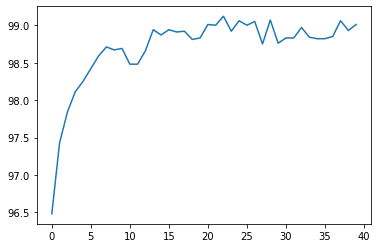

In [ ]:
lenet = train(40, device=device)

**Creating the Function to test validation data**

In [ ]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(lenet, val_dl)

**Confusion Matrix**

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,975,0,0,0,0,0,2,1,1,1
1,0,1134,0,0,0,0,1,0,0,0
2,2,0,1021,0,2,0,0,5,2,0
3,0,0,4,1000,0,1,0,4,1,0
4,0,0,0,0,976,0,1,1,0,4
5,1,0,0,4,0,885,2,0,0,0
6,4,3,0,0,3,1,945,0,2,0
7,0,1,1,0,0,0,0,1024,1,1
8,2,0,2,0,0,2,0,1,964,3
9,0,2,0,1,8,4,0,4,2,988


**Define Inference function to get prediction for any given image**

In [ ]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

**Getting the image from the web**

In [ ]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

**Showing the image**

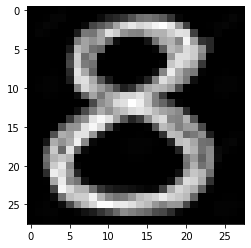

In [ ]:
plt.imshow(x.squeeze(-1), cmap="gray")

**Predictions**

In [ ]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 99.99819993972778 %


In [ ]:
pred

array([[7.6227497e-14, 3.3676224e-09, 4.7916572e-08, 3.7093875e-07,
        6.3032392e-11, 6.8031973e-06, 1.0854477e-05, 1.9794424e-18,
        9.9998200e-01, 1.3703315e-12]], dtype=float32)